# Classifying Pets
This notebook roughly follows the fastai practical deep learning course, while aggregating some information from the different notebooks in the course.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import vision # no import * because ¯\_(ツ)_/¯
import os
from matplotlib import gridspec
import matplotlib.cm as cm
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from torch import nn

In [2]:
bs = 64 # set batch size
path = vision.untar_data(vision.URLs.PETS)/'images' # fastai path has some nice wrappers for the pathlib

## Generate dataset
Create a databunch from folders and set up data augmentation.
Generate a ImageList from the folder, classes are folder names. And split using the same random seed, being able to accurately compare models.

In [3]:
src = vision.ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

Choose data augmentation transforms to be applied to the images on loading into the batch.

In [4]:
tfms = vision.get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(vision.imagenet_stats))

In [6]:
data = get_data(224, bs, "zeros")

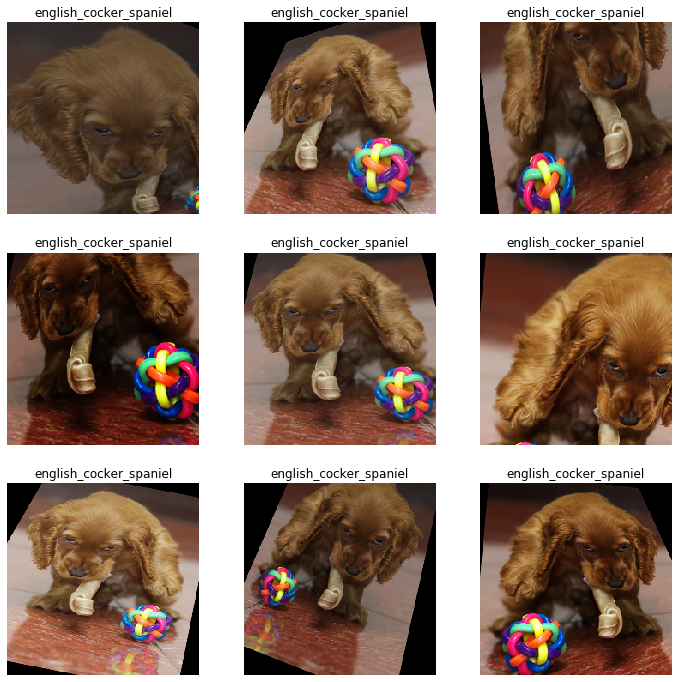

In [7]:
def _plot(i,j,ax):
    x,y = data.train_ds[219]
    x.show(ax, y=y)

vision.plot_multi(_plot, 3, 3, figsize=(12,12))

### Training
Generate and train a conv learner for 10 cycles.
Maximum learning rates for lr_cycler are sliced from a minimum uf 1e-6 for the very deep layers to 1e-3 for the higher layers.
Thus, the low-level features essentially stay the same or only get a slight upate.

In [8]:
learn = vision.cnn_learner(data, vision.models.resnet50, metrics=[vision.accuracy], bn_final=True)
vision.gc.collect()

0

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3), pct_start=0.8)

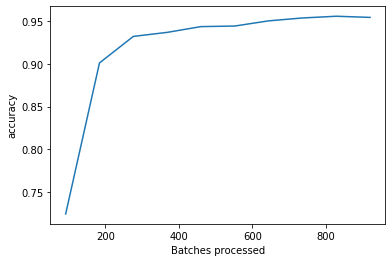

In [173]:
learn.recorder.plot_metrics()
plt.savefig("metrics.png", dpi=300)

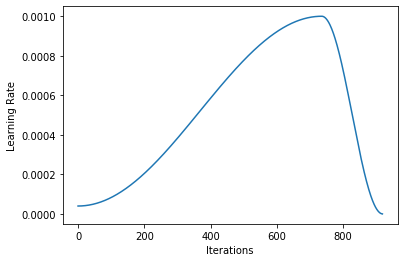

In [10]:
learn.recorder.plot_lr()
plt.savefig("lr.png", dpi=300)

Create an untrained conv learner for examining the features that have changed.

In [88]:
learn_untrained = vision.cnn_learner(data, vision.models.resnet50, metrics=[vision.accuracy], bn_final=True)
vision.gc.collect()

0

In [166]:
def hooked_backward(m, cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            print(f'preds: {preds}')
            preds[0,int(cat)].backward()
    return hook_a,hook_g

def show_heatmap(hm):
    _,ax = plt.subplots(figsize=(10,16))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');
    
def plot_activation_grid(acts_untrained, acts_trained, size=8):
    fig = plt.figure(figsize=(24, 12))

    gs0 = gridspec.GridSpec(1, 2)
    gs00 = gridspec.GridSpecFromSubplotSpec(size, size, subplot_spec=gs0[0])
    gs01 = gridspec.GridSpecFromSubplotSpec(size, size, subplot_spec=gs0[1])

    for i in range(size):
        for j in range(size):
            ax00 = fig.add_subplot(gs00[i, j])
            ax00.imshow(acts_untrained[i * size + j], cmap=cm.Greys_r)
            ax00.axis('off')
            ax01 = fig.add_subplot(gs01[i, j])
            ax01.imshow(acts_trained[i * size + j], cmap=cm.Greys_r)
            ax01.axis('off')


### Evaluation
To directly visualize the activations of the conv filters, a new model is created from both learners.
This new model also takes images as input, but instead of predicting classes, it outputs the activations of an intermediate convolutional layer.

In [169]:
m = learn.model.eval()
res50_conv = nn.Sequential(*list(list(m.children())[0])[:-2])

In [155]:
m_untrained = learn_untrained.model.eval()
res50_conv_untrained = nn.Sequential(*list(list(m_untrained.children())[0])[:-2])

Select an image from the dataset to examine

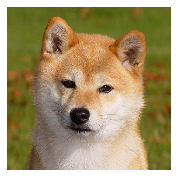

In [170]:
idx=433
data = get_data(352, bs)
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
xb,_ = data.one_item(x)
xb_im = vision.Image(data.denorm(xb)[0])
xb = xb.cuda()

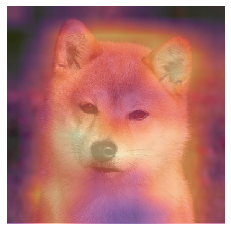

In [100]:
hook_a,hook_g = hooked_backward(m_untrained)
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

Average activations before training. All activations are a little bit blurred and undefined.

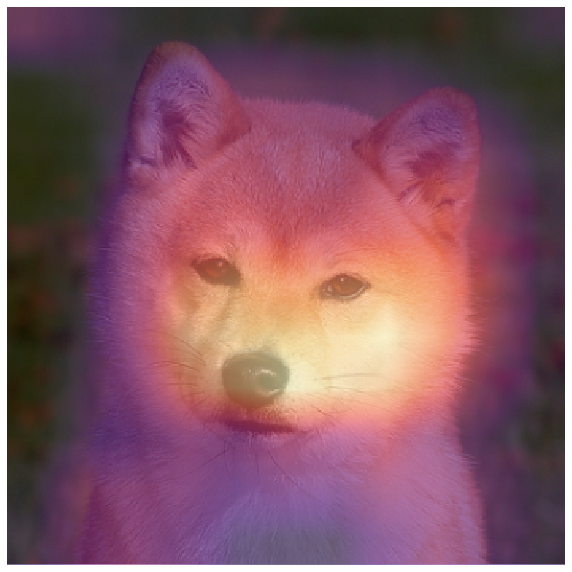

In [142]:
hook_a,hook_g = hooked_backward(m)
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

Average activations after training. The dog ist central.

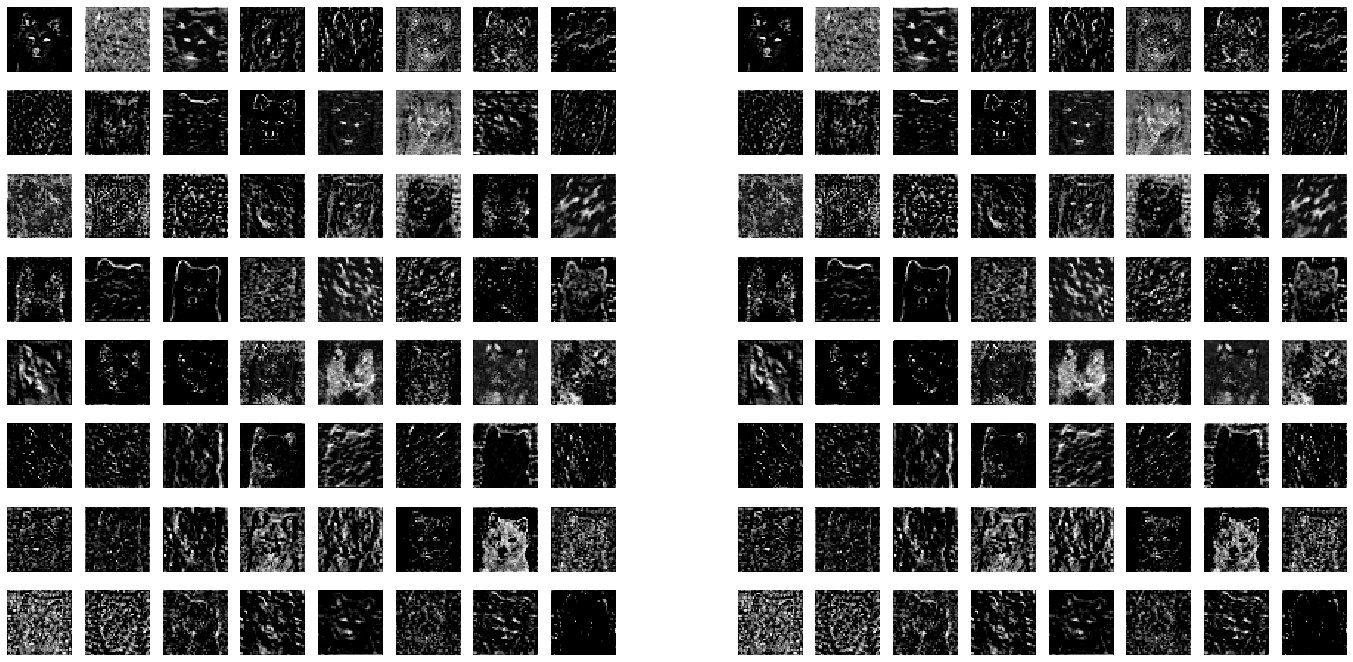

In [171]:
acts = res50_conv(xb).detach().cpu().numpy()
acts_untrained = res50_conv_untrained(xb).detach().cpu().numpy()
plot_activation_grid(acts_untrained[0], acts[0])

Compare the feature maps of the untrained network to the feature maps of the trained network. All feature maps look very similar, thus the features learned so far on the ImageNet dataset are mostly good for the pet classification task (which is expected, since this is the whole point of doing transfer learning). But taking a closer look, the features after training are somewhat more defined.

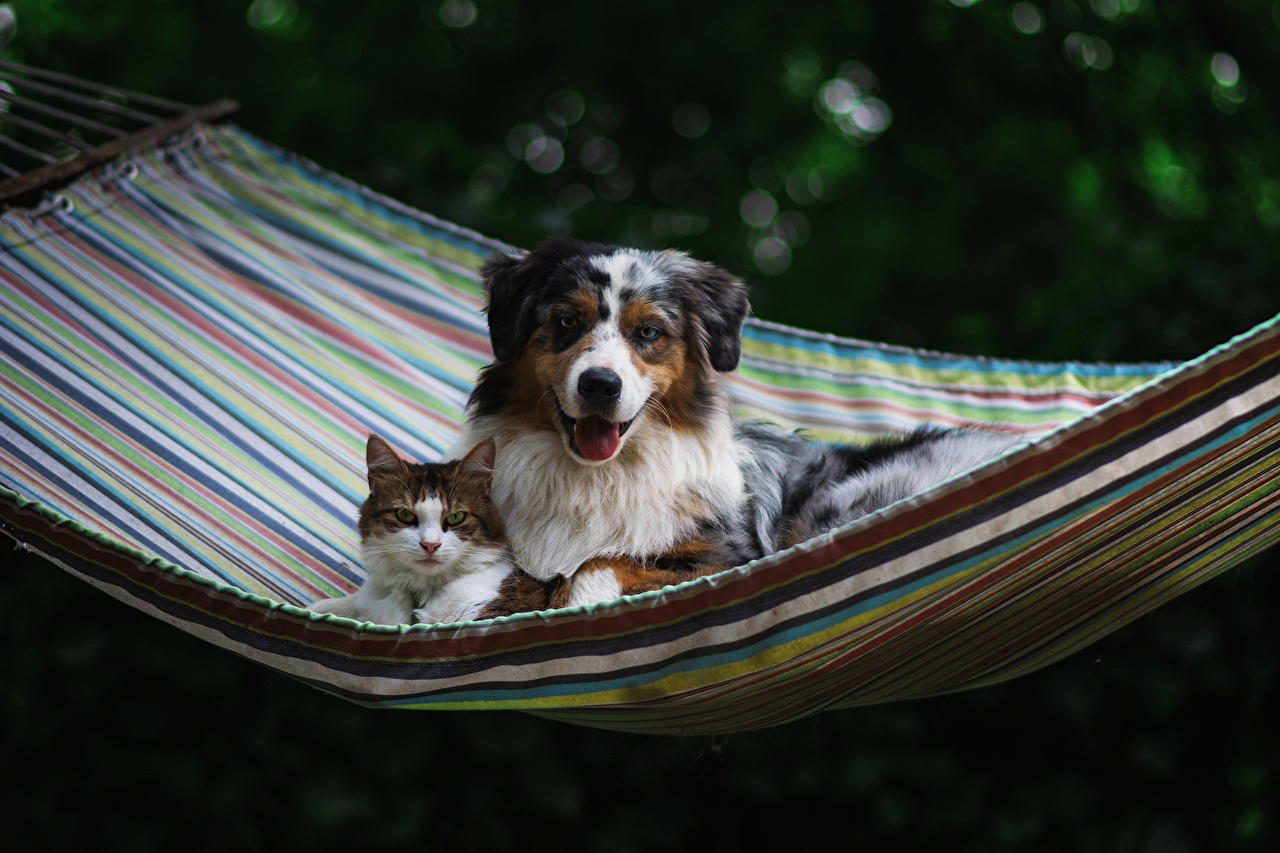

In [158]:
filename = 'cat_dog.jpg'
x = vision.open_image(filename)
x

A picture of a dog and a cat, not contained in the dataset.

In [159]:
xb, _ = data.one_item(x)
xb_im = vision.Image(data.denorm(xb)[0])
xb = xb.cuda()

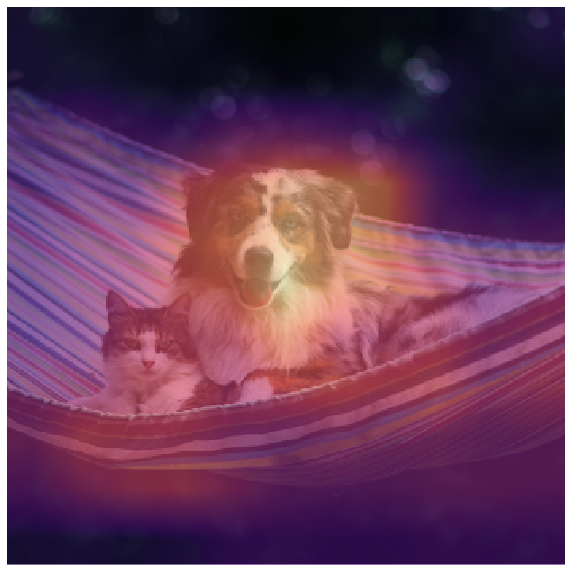

In [136]:
hook_a,hook_g = hooked_backward(m_untrained)
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

Average activations before training: Despite the dog being more highlighted, high activations can be seen throught the whole image. Notably, the cat is not being very highlighted, or getting much attention of the model.

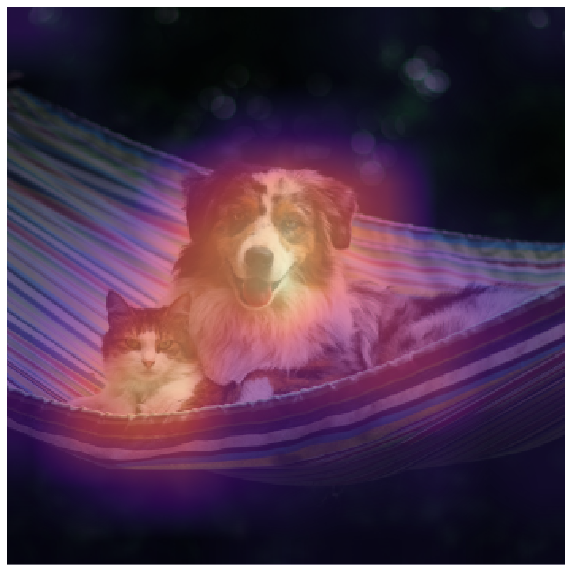

In [161]:
hook_a,hook_g = hooked_backward(m, cat=11)
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

After training, activations clearly focus on the dog and the cat. Further, the cat is now clearly highlighted.